# LSTM
- Air Quality Data in India
- https://www.kaggle.com/rohanrao/air-quality-data-in-india
- city_day.csv

# Data processing

## Load data

In [1]:
import numpy as np
import pandas as pd
#df_all = pd.read_csv('city_day.csv')
df_all = pd.read_csv('https://github.com/nnnpooh/energy-class/blob/main/T4%20-%20LSTM/city_day.csv?raw=true')
df_all.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


## Filtering

In [2]:
# Filter only Delhi
df_delhi = df_all.loc[df_all['City'] == 'Delhi'].copy()
df_delhi.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
10229,Delhi,2015-01-01,313.22,607.98,69.16,36.39,110.59,33.85,15.20,9.25,41.68,14.36,24.86,9.84,472.0,Severe
10230,Delhi,2015-01-02,186.18,269.55,62.09,32.87,88.14,31.83,9.54,6.65,29.97,10.55,20.09,4.29,454.0,Severe
10231,Delhi,2015-01-03,87.18,131.90,25.73,30.31,47.95,69.55,10.61,2.65,19.71,3.91,10.23,1.99,143.0,Moderate
10232,Delhi,2015-01-04,151.84,241.84,25.01,36.91,48.62,130.36,11.54,4.63,25.36,4.26,9.71,3.34,319.0,Very Poor
10233,Delhi,2015-01-05,146.60,219.13,14.01,34.92,38.25,122.88,9.20,3.33,23.20,2.80,6.21,2.96,325.0,Very Poor


In [3]:
# Choose 2 columns
df_delhi = df_delhi[['Date','AQI']]
df_delhi.head()

,Date,AQI
10229,2015-01-01,472.0
10230,2015-01-02,454.0
10231,2015-01-03,143.0
10232,2015-01-04,319.0
10233,2015-01-05,325.0


In [4]:
# Set index
df_delhi['Date'] = pd.to_datetime(df_delhi['Date'])
df = df_delhi.set_index('Date')
df.head()

,AQI
Date,
2015-01-01,472.0
2015-01-02,454.0
2015-01-03,143.0
2015-01-04,319.0
2015-01-05,325.0


## Resampling
- Day resampling (D)
- There is missing data.

In [5]:
max_sample = -1
df_avg = df['AQI'].resample('D').mean()
if max_sample > 0:
    df_avg = df_avg.iloc[-max_sample-1:-1]
# Make sure we have the dataframe at the end
df_avg = pd.DataFrame(df_avg)
df_avg.columns = ['y']
df_avg.head()

,y
Date,
2015-01-01,472.0
2015-01-02,454.0
2015-01-03,143.0
2015-01-04,319.0
2015-01-05,325.0


## Check for missing values

In [6]:
df_avg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2009 entries, 2015-01-01 to 2020-07-01
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       1999 non-null   float64
dtypes: float64(1)
memory usage: 31.4 KB


In [7]:
# Show missing values
df_missing = df_avg[df_avg.isna().any(axis=1)]
df_missing

,y
Date,
2016-07-24,NaN
2017-06-23,NaN
2017-08-13,NaN
2017-08-14,NaN
2017-08-22,NaN
2017-08-23,NaN
2017-08-26,NaN
2017-08-27,NaN
2017-08-28,NaN


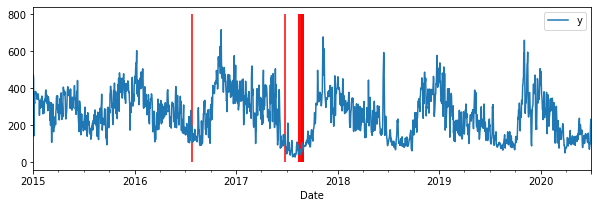

In [8]:
import matplotlib.pyplot as plt
x_missing = df_missing.index
fig, ax = plt.subplots(figsize=(10,3))
df_avg.plot(ax=ax)
ax.vlines(x_missing,0,800, color='r')
plt.show()

## Fill in missing values using rolling average

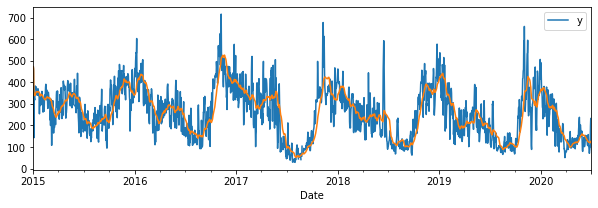

In [9]:
df_rolling = df_avg['y'].rolling(24,min_periods=1,).mean()

# Plotting
fig, ax = plt.subplots(figsize=(10,3))
df_avg.plot(ax=ax)
df_rolling.plot(ax=ax)
plt.show()

In [10]:
# Fill in the missing value
df_avg['y'] = df_avg['y'].fillna(df_rolling)

In [11]:
# No more missing values
df_avg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2009 entries, 2015-01-01 to 2020-07-01
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       2009 non-null   float64
dtypes: float64(1)
memory usage: 31.4 KB


## Scaling data

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_avg['y (scaled)'] = scaler.fit_transform(df_avg[['y']])
display(df_avg.head())

,y,y (scaled)
Date,,
2015-01-01,472.0,0.644833
2015-01-02,454.0,0.618632
2015-01-03,143.0,0.165939
2015-01-04,319.0,0.422125
2015-01-05,325.0,0.430859


## Converting time series into supervised data

In [13]:
window_size = 10

In [14]:
dft = df_avg.copy()
dft['split'] = ''
for i in range(1, window_size + 1):
    col = f"t-{i}" 
    dft[col] = dft.iloc[:,1].shift(i)
display(dft.head())
display(dft.tail())

,y,y (scaled),split,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
Date,,,,,,,,,,,,,
2015-01-01,472.0,0.644833,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,454.0,0.618632,,0.644833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-03,143.0,0.165939,,0.618632,0.644833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,319.0,0.422125,,0.165939,0.618632,0.644833,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,325.0,0.430859,,0.422125,0.165939,0.618632,0.644833,NaN,NaN,NaN,NaN,NaN,NaN


,y,y (scaled),split,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
Date,,,,,,,,,,,,,
2020-06-27,112.0,0.120815,,0.109170,0.082969,0.061135,0.081514,0.109170,0.110626,0.187773,0.149927,0.113537,0.117904
2020-06-28,196.0,0.243086,,0.120815,0.109170,0.082969,0.061135,0.081514,0.109170,0.110626,0.187773,0.149927,0.113537
2020-06-29,233.0,0.296943,,0.243086,0.120815,0.109170,0.082969,0.061135,0.081514,0.109170,0.110626,0.187773,0.149927
2020-06-30,114.0,0.123726,,0.296943,0.243086,0.120815,0.109170,0.082969,0.061135,0.081514,0.109170,0.110626,0.187773
2020-07-01,101.0,0.104803,,0.123726,0.296943,0.243086,0.120815,0.109170,0.082969,0.061135,0.081514,0.109170,0.110626


In [15]:
dft = dft.dropna()

## Split data into training and testing set

In [16]:
test_size = 0.2
n_rows = dft.shape[0]
train_size = int(n_rows * (1-test_size))
test_size = n_rows - train_size
dft.iloc[0:train_size, 2] = 'train'
dft.iloc[train_size:, 2] = 'test'

In [17]:
dft.head()

,y,y (scaled),split,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
Date,,,,,,,,,,,,,
2015-01-11,379.0,0.509461,train,0.505095,0.503639,0.515284,0.471616,0.420670,0.430859,0.422125,0.165939,0.618632,0.644833
2015-01-12,375.0,0.503639,train,0.509461,0.505095,0.503639,0.515284,0.471616,0.420670,0.430859,0.422125,0.165939,0.618632
2015-01-13,366.0,0.490539,train,0.503639,0.509461,0.505095,0.503639,0.515284,0.471616,0.420670,0.430859,0.422125,0.165939
2015-01-14,353.0,0.471616,train,0.490539,0.503639,0.509461,0.505095,0.503639,0.515284,0.471616,0.420670,0.430859,0.422125
2015-01-15,340.0,0.452693,train,0.471616,0.490539,0.503639,0.509461,0.505095,0.503639,0.515284,0.471616,0.420670,0.430859


In [18]:
filt = dft['split'] == 'train'
X_train = dft[filt].iloc[:,3:].values
y_train = dft[filt].iloc[:,1].values
#
filt = dft['split'] == 'test'
X_test = dft[filt].iloc[:,3:].values
y_test = dft[filt].iloc[:,1].values
#
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1599, 10)
(400, 10)
(1599,)
(400,)


## Reshape input data for LSTM traning
- Dimension: \[samples, time steps, features\]


In [19]:
X_train_rs = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_rs = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
#
print(X_train_rs.shape)
print(X_test_rs.shape)

(1599, 1, 10)
(400, 1, 10)


# Training model

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session

## Model building

In [21]:
# Clear session
clear_session()
model = Sequential()

model.add(LSTM(200, input_shape=(X_train_rs.shape[1], X_train_rs.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

In [22]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               168800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 169,001
Trainable params: 169,001
Non-trainable params: 0
_________________________________________________________________
None


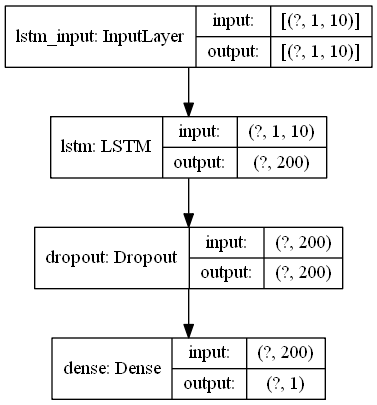

In [23]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [24]:
model.compile(loss='mean_squared_error', optimizer='adam')

## Training

In [25]:
history = model.fit(X_train_rs, y_train, epochs=100, batch_size=10, validation_data=(X_test_rs, y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=20)], verbose=1, shuffle=False)

model.summary()

Epoch 1/100
160/160 [==============================] - 1s 6ms/step - loss: 0.0176 - val_loss: 0.0086
Epoch 2/100
160/160 [==============================] - 0s 3ms/step - loss: 0.0096 - val_loss: 0.0070
Epoch 3/100
160/160 [==============================] - 0s 3ms/step - loss: 0.0082 - val_loss: 0.0060
Epoch 4/100
160/160 [==============================] - 0s 3ms/step - loss: 0.0076 - val_loss: 0.0056
Epoch 5/100
160/160 [==============================] - 0s 3ms/step - loss: 0.0073 - val_loss: 0.0054
Epoch 6/100
160/160 [==============================] - 0s 3ms/step - loss: 0.0071 - val_loss: 0.0052
Epoch 7/100
160/160 [==============================] - 0s 3ms/step - loss: 0.0069 - val_loss: 0.0051
Epoch 8/100
160/160 [==============================] - 0s 3ms/step - loss: 0.0067 - val_loss: 0.0050
Epoch 9/100
160/160 [==============================] - 0s 3ms/step - loss: 0.0069 - val_loss: 0.0051
Epoch 10/100
160/160 [==============================] - 1s 3ms/step - loss: 0.0066 - val_lo

## Predictions

In [26]:
# Creating new DataFrame to store results
dft_result = dft.iloc[:,0:3]

# Model predictions
y_pred_train = model.predict(X_train_rs)
y_pred_test = model.predict(X_test_rs)
y_pred = np.concatenate((y_pred_train, y_pred_test), axis=0)

# Invert predictions
y_pred_pl = scaler.inverse_transform(y_pred)

# Storing results
dft_result['y_pred (scaled)'] = y_pred 
dft_result['y_pred'] = y_pred_pl

In [27]:
dft_result.head()

,y,y (scaled),split,y_pred (scaled),y_pred
Date,,,,,
2015-01-11,379.0,0.509461,train,0.504402,375.524109
2015-01-12,375.0,0.503639,train,0.489012,364.951416
2015-01-13,366.0,0.490539,train,0.468924,351.150635
2015-01-14,353.0,0.471616,train,0.474323,354.860016
2015-01-15,340.0,0.452693,train,0.459099,344.400787


## Evaluation

In [28]:
def model_eval(df_eval):
    MAE = df_eval['error'].abs().mean()
    RMSE = np.sqrt((df_eval['error']**2).mean())
    MAPE = df_eval['percentage'].abs().mean()
    print(f"-------")
    print(f"Mean absolute error: {MAE:6.3f}")
    print(f"Root mean squared error: {RMSE:6.3f}")
    print(f"Mean absolute percentage error: {MAPE:6.3f}")

In [29]:
dft_result['error'] = dft_result['y'] - dft_result['y_pred']
dft_result['percentage'] = dft_result['error']/dft_result['y']*100

dft_eval = dft_result[dft_result['split'] == 'train']
print(f"Training")
model_eval(dft_eval)

print(f"\nTesting")
dft_eval = dft_result[dft_result['split'] == 'test']
model_eval(dft_eval)

print(f"\nAll")
model_eval(dft_result)

Training
-------
Mean absolute error: 37.989
Root mean squared error: 50.600
Mean absolute percentage error: 16.407

Testing
-------
Mean absolute error: 31.876
Root mean squared error: 43.648
Mean absolute percentage error: 17.743

All
-------
Mean absolute error: 36.766
Root mean squared error: 49.288
Mean absolute percentage error: 16.674


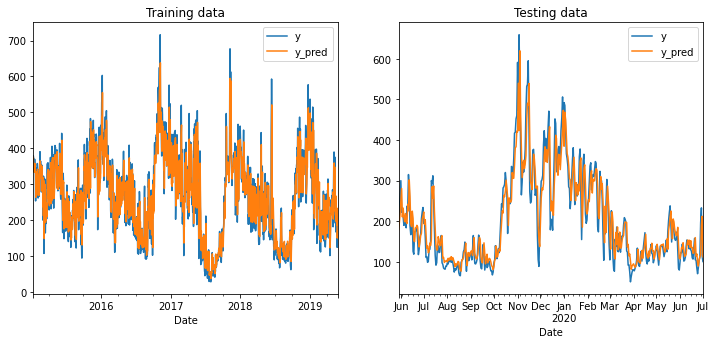

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

dft_plot = dft_result[dft_result['split'] == 'train']
dft_plot[['y', 'y_pred']].plot(ax=ax1)
ax1.set_title('Training data')

dft_plot = dft_result[dft_result['split'] == 'test']
dft_plot[['y', 'y_pred']].plot(ax=ax2)
ax2.set_title('Testing data')

plt.show()

# Forecasting

## Retrain the model with entire data

In [31]:
# Extract data
X_train = dft.iloc[:,3:].values
y_train = dft.iloc[:,1].values

# Reshape data
X_train_rs = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

print(X_train_rs.shape)
print(y_train.shape)

(1999, 1, 10)
(1999,)


In [32]:
history = model.fit(X_train_rs, y_train, epochs=100, batch_size=10, validation_data=(X_test_rs, y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=20)], verbose=1, shuffle=False)

model.summary()

Epoch 1/100
200/200 [==============================] - 1s 3ms/step - loss: 0.0058 - val_loss: 0.0040
Epoch 2/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0040
Epoch 3/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0039
Epoch 4/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0039
Epoch 5/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0039
Epoch 6/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0039
Epoch 7/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0039
Epoch 8/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0039
Epoch 9/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0039
Epoch 10/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0057 - val_lo

## Storing prediction result

In [33]:
y_pred = model.predict(X_train_rs)
y_pred_pl = scaler.inverse_transform(y_pred)
dft_result['y_pred_2 (scale)'] = y_pred
dft_result['y_pred_2'] = y_pred_pl
display(dft_result.head())

,y,y (scaled),split,y_pred (scaled),y_pred,error,percentage,y_pred_2 (scale),y_pred_2
Date,,,,,,,,,
2015-01-11,379.0,0.509461,train,0.504402,375.524109,3.475891,0.917122,0.521429,387.221619
2015-01-12,375.0,0.503639,train,0.489012,364.951416,10.048584,2.679622,0.502552,374.253174
2015-01-13,366.0,0.490539,train,0.468924,351.150635,14.849365,4.057204,0.477361,356.946716
2015-01-14,353.0,0.471616,train,0.474323,354.860016,-1.860016,-0.526917,0.486053,362.918549
2015-01-15,340.0,0.452693,train,0.459099,344.400787,-4.400787,-1.294349,0.470311,352.103546


## Forecasting

In [34]:
n_forecast = 10

In [35]:
y = dft_result['y (scaled)'].values
freq = dft_result.index.freq
dt_last = dft_result.index[-1]
dts = []
for i in range(1,n_forecast+1):
    x = y[-window_size-1:-1]
    x = x.reshape(1,1,-1)
    y = np.append(y,model.predict(x).flatten())
    dts.append(dt_last + freq * i)

y_fore = y[-n_forecast-1:-1]
y_fore_pl = scaler.inverse_transform([y_fore]).ravel()

dft_forecast = pd.DataFrame( {'date_time': dts, 'y_fore (scaled)': y_fore, 'y_fore': y_fore_pl} )
dft_forecast = dft_forecast.set_index('date_time')
dft_forecast.head()

,y_fore (scaled),y_fore
date_time,,
2020-07-02,0.104803,101.000000
2020-07-03,0.114006,107.321957
2020-07-04,0.115810,108.561679
2020-07-05,0.098616,96.749195
2020-07-06,0.078718,83.079015


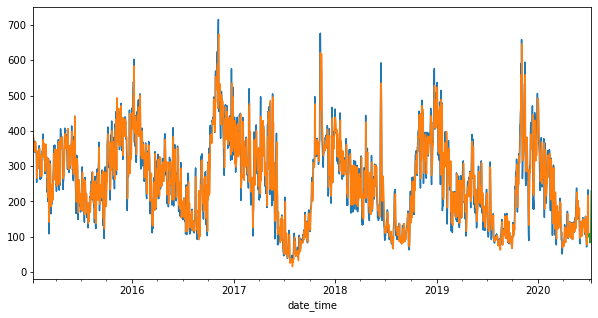

In [36]:
fig, ax = plt.subplots(figsize=(10,5))
dft_result['y'].plot(ax=ax)
dft_result['y_pred_2'].plot(ax=ax)
dft_forecast['y_fore'].plot(ax=ax)
plt.show()

(0.0, 300.0)

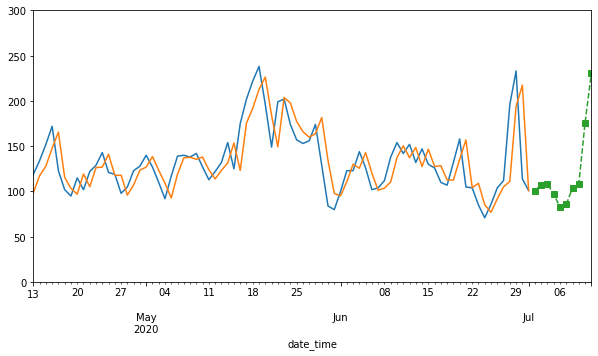

In [37]:
fig, ax = plt.subplots(figsize=(10,5))
dft_result['y'].plot(ax=ax)
dft_result['y_pred_2'].plot(ax=ax)
dft_forecast['y_fore'].plot(ax=ax,linestyle='--',marker='s')

dt_start = dft_result.index[-n_forecast*8]
dt_end = dft_forecast.index[-1]
ax.set_xlim(dt_start,dt_end)
ax.set_ylim(0,300)